In [10]:
import os
import torch
import torch.optim as optim
import torchvision
from tqdm import tqdm
import sys
import time
import matplotlib.pyplot as plt

from ddpm import config as _config
from ddpm.config import cifar10_config
from ddpm.data import get_cifar10_dataloaders
from ddpm.diffusion_model import DiffusionModel

In [ ]:
_config.DEBUG = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("System info: ")
print("Device:", device)
print("GPU Device:", torch.cuda.get_device_name(0))
print("GPU RAM:", f"{(torch.cuda.get_device_properties(0).total_memory / 1e9).__round__(2)} GB")

cifar10_config.res_net_config.initial_pad = 0
batch_size = cifar10_config.batch_size

# max_epochs = 500
max_epochs = 5

learning_rate = 1e-4

System info: 
Device= cuda
GPU Device:  NVIDIA GeForce RTX 3060 Laptop GPU
GPU RAM:  6.441926656


In [12]:
destination_folder = "tmp"

In [13]:
os.makedirs(destination_folder, exist_ok=True)
os.makedirs(f"{destination_folder}/samples", exist_ok=True)

In [14]:
train_loader, test_loader = get_cifar10_dataloaders(batch_size=batch_size)

In [15]:
model = DiffusionModel(cifar10_config).to(device)

# Create an EMA model (exact copy of the original model)
model_ema = DiffusionModel(cifar10_config).to(device)
model_ema.load_state_dict(model.state_dict())
model_ema.eval()

# Utility function to update EMA weights
def update_ema(model, ema_model, alpha=0.9999):
    """EMA update for each parameter."""
    with torch.no_grad():
        for p, p_ema in zip(model.parameters(), ema_model.parameters()):
            p_ema.data = alpha * p_ema.data + (1 - alpha) * p.data


In [16]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# CosineAnnealingLR will decay the LR smoothly over max_epochs
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
times = []
losses = []


In [17]:
for epoch in range(max_epochs):
    t0 = time.time()
    model.train()
    batch_progress = tqdm(train_loader, desc=f"Epoch {epoch}", leave=False)

    for batch_idx, (images, labels) in enumerate(batch_progress):
        images = images.to(device)
        labels = labels.to(device)

        loss = model(images, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        update_ema(model, model_ema)
        
        batch_progress.set_postfix(loss=loss.item())
        sys.stdout.flush()
        
    scheduler.step()

    current_lr = scheduler.get_last_lr()[0]
    tqdm.write(f"Epoch {epoch}, loss={loss.item():.4f}, LR={current_lr}")

    model_ema.eval()
    with torch.no_grad():
        # Let's pick random class labels for 16 samples
        labels_for_sampling = torch.randint(low=0, high=10, size=(16,), device=device)
        samples = model_ema.sample(
            shape=(16, 3, 32, 32),
            device=device,
            y=labels_for_sampling
        )

    samples = (samples.clamp(-1, 1) + 1) / 2

    img_name = f"{destination_folder}/samples/generated_samples_epoch_{epoch}.png"
    torchvision.utils.save_image(samples, img_name, nrow=4)
    times.append(time.time() - t0)
    losses.append(loss.item())

Epoch 0, loss=0.0204, LR=9.045084971874738e-05


Epoch 1, loss=0.0274, LR=6.545084971874737e-05


Epoch 2, loss=0.0160, LR=3.454915028125263e-05


Epoch 3, loss=0.0425, LR=9.549150281252631e-06


Epoch 4, loss=0.0333, LR=0.0


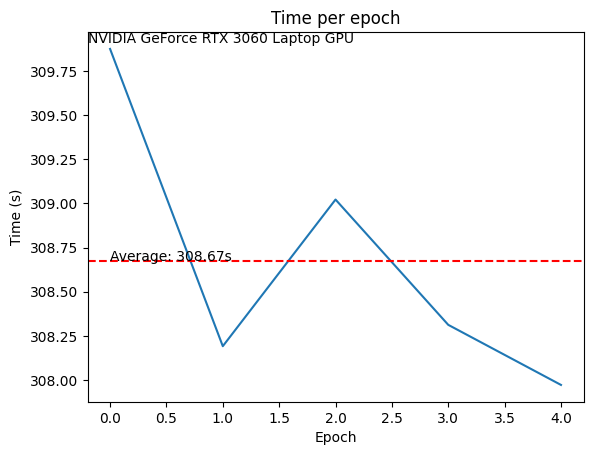

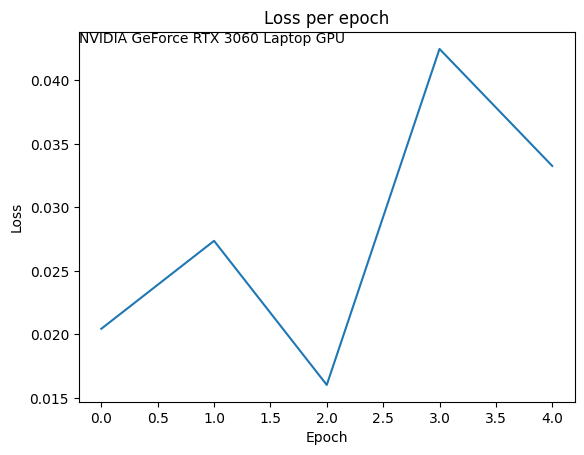

In [22]:
# plotting the time and loss
average_time = sum(times) / len(times)
plt.plot(times)
plt.title(f"Time per epoch")
plt.axhline(average_time, color="red", linestyle="--")
plt.text(0, average_time, f"Average: {average_time:.2f}s")
plt.text(0, 1, f"{torch.cuda.get_device_name(0)}", transform=plt.gca().transAxes, ha='left', va='top')
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.show()


plt.plot(losses)
plt.title(f"Loss per epoch")
plt.text(0, 1, f"{torch.cuda.get_device_name(0)}", transform=plt.gca().transAxes, ha='left', va='top')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [19]:
torch.save({
    'model_state': model.state_dict(),
    'model_ema_state': model_ema.state_dict(),
    'optimizer_state': optimizer.state_dict(),
    'epoch': epoch
}, f"{destination_folder}/diffusion_model_checkpoint.pth")

print("Training complete, model and EMA weights saved.")

Training complete, model and EMA weights saved.
